Load DATA 

In [87]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
import numpy as np
from pgmpy.inference import VariableElimination  # Import VariableElimination from pgmpy.inference
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pgmpy.base import DAG


In [88]:
dataset_path = "Mental Health Dataset.csv"
df = pd.read_csv(dataset_path, sep=';')

# Fill any missing Values

In [89]:

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().any():  # Check if there are missing values in the column
        df[col] = df[col].fillna(df[col].mode()[0])  # Fill missing values with mode

# Save the dataset with filled missing values to a CSV file
df.to_csv("filled_dataset.csv", index=False)


# PERFORM ONE HOT ENCODING

In [90]:
# Load the dataset (if not already loaded)
file_path = "filled_dataset.csv"  # Replace "filled_dataset.csv" with the path to your filled dataset
df_filled = pd.read_csv(file_path)

# Shuffle the dataset
df_filled = df_filled.sample(frac=1, random_state=42).reset_index(drop=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical variables using label encoding
categorical_cols = df_filled.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_filled[col] = label_encoder.fit_transform(df_filled[col])

# Display the encoded dataset
df_filled.to_csv("filled_dataset_encoding.csv", index=False)

# Now we get Test,Validation and Train data

In [91]:
# Define the desired sizes for the reduced datasets
train_data = df_filled[:60000]
val_data = df_filled[60000:80000]
test_data = df_filled[80000:100000]

train_data.to_csv("train_dataset.csv", index=False)
# Display the shape of each dataset
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (60000, 17)
Validation data shape: (20000, 17)
Test data shape: (20000, 17)


# DEFINING THE MODEL

In [92]:
# Initialize BayesianModel
edges =[
    ('Gender', 'treatment'),
    ('Country', 'Occupation'),
    ('Country', 'self_employed'),
    ('Occupation', 'self_employed'),
    ('Occupation', 'treatment'),
    ('self_employed', 'treatment'),
    ('Mental_Health_History', 'Mood_Swings'),
    ('Mental_Health_History', 'Coping_Struggles'),
    ('Mood_Swings', 'treatment'),
    ('Coping_Struggles', 'treatment'),
    ('family_history', 'treatment'),
    ('Days_Indoors', 'treatment'),
    ('Growing_Stress', 'Coping_Struggles'),
    ('Mood_Swings', 'Coping_Struggles'),
    ('Changes_Habits', 'treatment'),
    ('Work_Interest', 'treatment'),
    ('Social_Weakness', 'treatment'),
    ('mental_health_interview', 'treatment'),
    ('care_options', 'treatment')
]



# TRAINING THE MODEL

In [93]:

# # Perform Hill climb search for the best model structure
# hc = HillClimbSearch(train_data)
# bic = BicScore(train_data)
# best_model_structure = hc.estimate(scoring_method=bic)

# # # Create the Bayesian model from the best structure

# # Fit the model using the training data
# best_model_structure.fit(train_data, estimator=MaximumLikelihoodEstimator)

# is_valid = model.check_model()
# # Check if CPDs are associated with all variables
# print(model.get_cpds())
# print(is_valid)

# Get the variables in the dataset
variables = train_data.columns.tolist()

# Create a Directed Acyclic Graph (DAG) with the same variables
start_dag = DAG()
start_dag.add_nodes_from(variables)

# Add edges from 'treatment' to all other variables except itself
for factor in variables:
    if factor != 'treatment':
        start_dag.add_edge(factor,'treatment' )

# Initialize HillClimbSearch object
hc = HillClimbSearch(train_data)

# Initialize BIC score
bic = BicScore(train_data)

# Perform Hill climb search for the best model structure
best_model_structure = hc.estimate(tabu_length=10, max_indegree=3, start_dag=start_dag, scoring_method=bic)

# Create the Bayesian model from the best structure
model = BayesianNetwork(best_model_structure.edges())

# Fit the model using the training data
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

is_valid = model.check_model()
print("Is this a Bayesian Network?",is_valid)

  0%|          | 0/1000000 [00:00<?, ?it/s]

Is this a Bayesian Network? True


# BAYESIAN NETWORK DIAGRAM

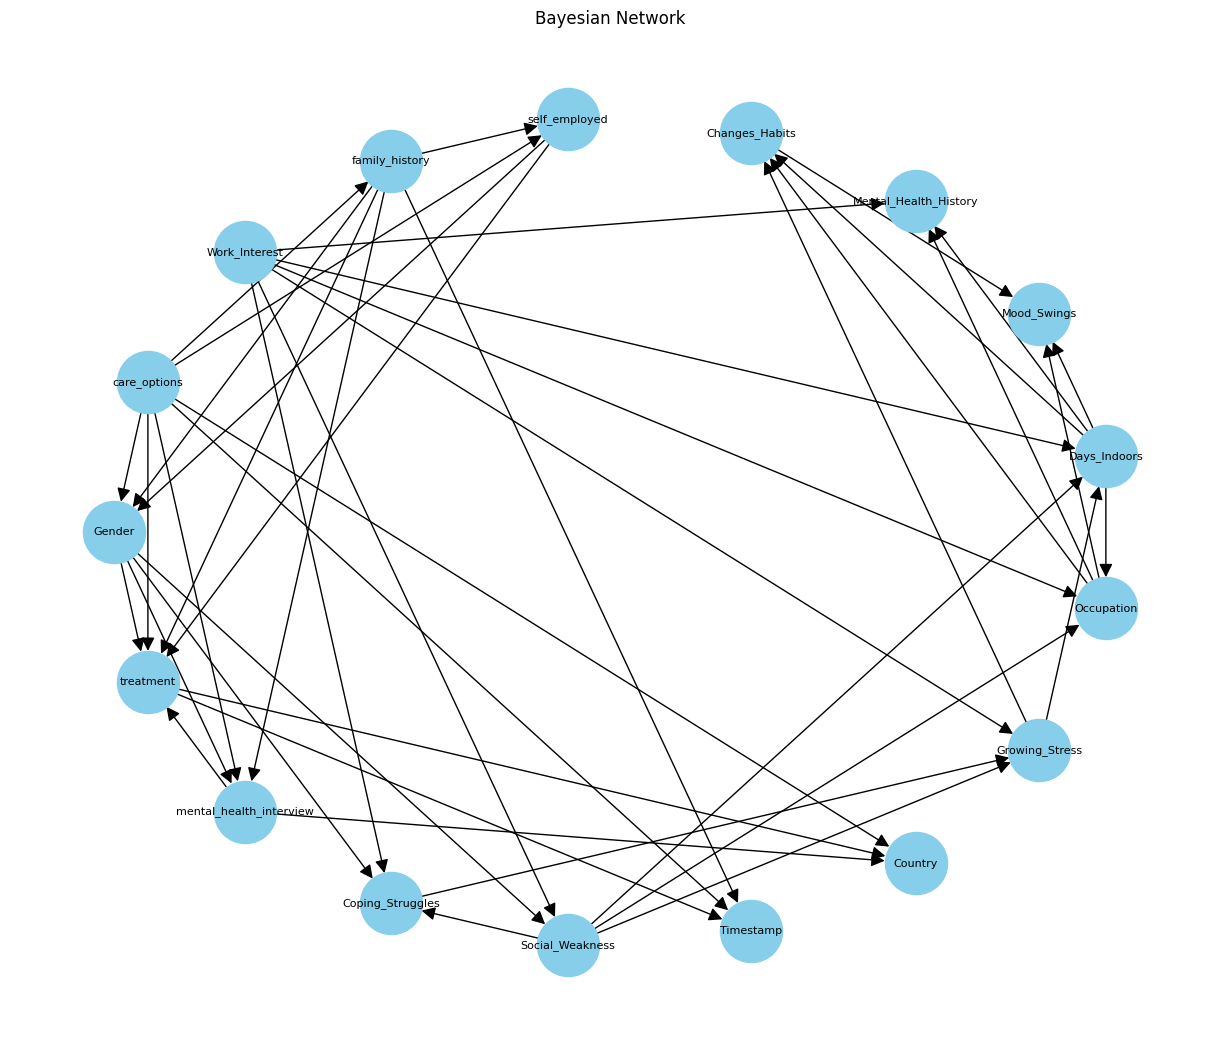

In [106]:
# Define the Bayesian network structure with V-structure and additional edges
# Visualize the Bayesian Network structure using networkx
G = nx.DiGraph(model.edges())
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=8, arrowsize=20)
plt.title("Bayesian Network")
plt.show()

# INFERENCING THE MODEL

In [94]:
# Perform inference for treatment outcome prediction
inference = VariableElimination(model)

# PREDICTING THE MODEL WITH EVIDENCE

In [95]:
# Perform inference for treatment outcome prediction
inference = VariableElimination(model)

# Function to predict treatment outcome for a given dataset
def predict_treatment_outcome(data):
    y_pred = []
    for _, row in data.iterrows():
        evidence = row.drop(['treatment', 'Timestamp']).to_dict()
        # Perform inference using VariableElimination
        query_result = inference.query(variables=['treatment'], evidence=evidence)
        # Extract the probability of the positive class (treatment)
        prob_treatment = query_result.values[1]
        # Compare the probability of treatment with a threshold (e.g., 0.5)
        y_pred.append(prob_treatment > 0.5)
    return y_pred

# Predict treatment outcome for the validation set
val_y_pred = predict_treatment_outcome(val_data)
val_y_true = val_data['treatment']

# Predict treatment outcome for the test set
test_y_pred = predict_treatment_outcome(test_data)
test_y_true = test_data['treatment']

# PREDICTING MODEL WITHOUT EVIDENCE

In [96]:
# Function to predict treatment outcome for a given dataset without evidence
def predict_treatment_outcome_no_evidence(data):
    y_pred = []
    for _, row in data.iterrows():
        # Perform inference using VariableElimination without evidence
        query_result = inference.query(variables=['treatment'])
        # Extract the probability of the positive class (treatment)
        prob_treatment = query_result.values[1]
        # Compare the probability of treatment with a threshold (e.g., 0.5)
        y_pred.append(prob_treatment > 0.5)
    return y_pred

# Predict treatment outcome for the validation set without evidence
val_y_pred_no_evidence = predict_treatment_outcome_no_evidence(val_data)

# Predict treatment outcome for the test set without evidence
test_y_pred_no_evidence = predict_treatment_outcome_no_evidence(test_data)


# COMPAREING MODEL WITH EVIDENCE AND WITHOUT EVIDENCE

In [97]:
# Function to compare predictions with and without evidence and visualize the results
def compare_predictions(true_labels, pred_labels_with_evidence, pred_labels_no_evidence):
    correct_with_evidence = sum(true_labels == pred_labels_with_evidence)
    correct_no_evidence = sum(true_labels == pred_labels_no_evidence)
    total_samples = len(true_labels)
    
    accuracy_with_evidence = correct_with_evidence / total_samples
    accuracy_without_evidence = correct_no_evidence / total_samples

    # Visualize the comparison
    labels = ['With Evidence', 'Without Evidence']
    accuracies = [accuracy_with_evidence, accuracy_without_evidence]

    plt.bar(labels, accuracies, color=['blue', 'orange'])
    plt.xlabel('Prediction Method')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Prediction Methods')
    plt.ylim(0, 1)
    plt.show()
    print("Accuracy with evidence:", correct_with_evidence / total_samples)
    print("Accuracy without evidence:", correct_no_evidence / total_samples)
    
    # Visualize the comparison
    labels = ['With Evidence', 'Without Evidence']
    correct_predictions = [correct_with_evidence, correct_no_evidence]

    plt.bar(labels, correct_predictions, color=['blue', 'orange'])
    plt.xlabel('Prediction Method')
    plt.ylabel('Correct Predictions')
    plt.title('Comparison of Correct Predictions')
    plt.show()

    print("Correct predictions with evidence:", correct_with_evidence)
    print("Correct predictions without evidence:", correct_no_evidence)

# Compare predictions for the validation set

Validation Set Comparison:


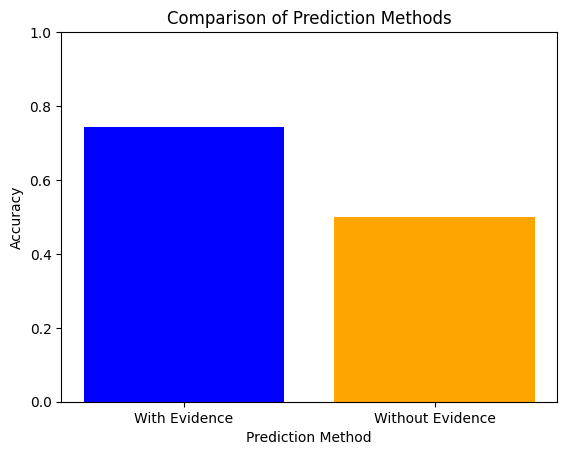

Accuracy with evidence: 0.7433
Accuracy without evidence: 0.5005


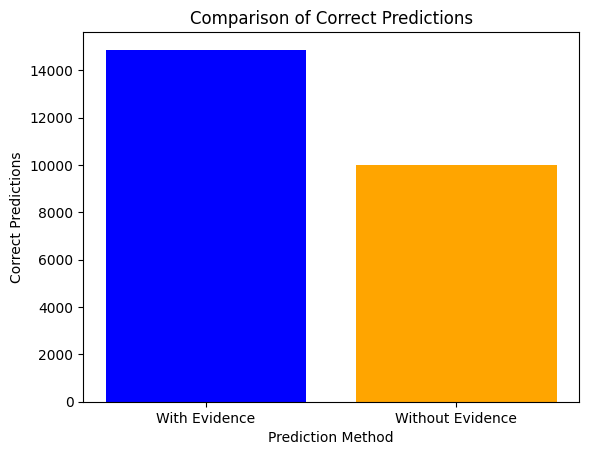

Correct predictions with evidence: 14866
Correct predictions without evidence: 10010


In [98]:
# Compare predictions for the validation set
print("Validation Set Comparison:")
compare_predictions(val_y_true, val_y_pred, val_y_pred_no_evidence)

# Compare predictions for the test set

Test Set Comparison:


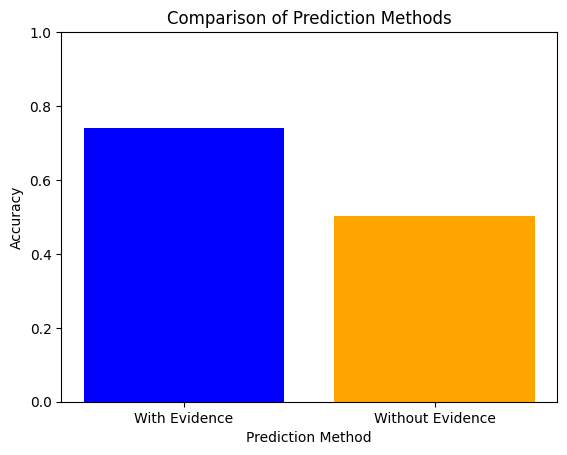

Accuracy with evidence: 0.74
Accuracy without evidence: 0.50125


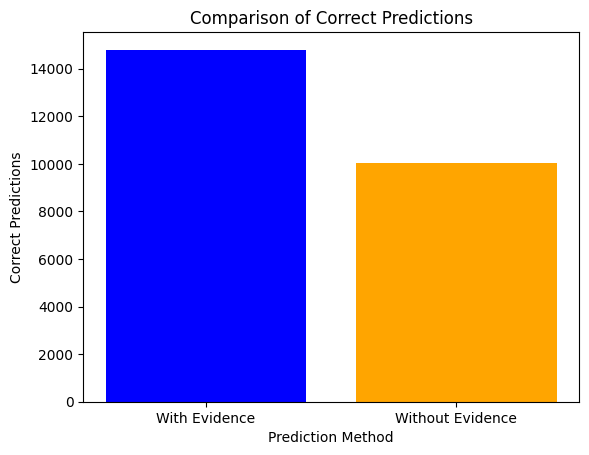

Correct predictions with evidence: 14800
Correct predictions without evidence: 10025


In [99]:
print("Test Set Comparison:")
compare_predictions(test_y_true, test_y_pred, test_y_pred_no_evidence)

# Calculating evaluation metrics with and without evidence

# TRUE LABELS and caluclating the evaluation metrics

In [100]:
# Function to calculate evaluation metrics
def calculate_evaluation_metrics(true_labels, pred_labels):
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    roc_auc = roc_auc_score(true_labels, pred_labels)
    return precision, recall, f1, roc_auc

# Function to compare evaluation metrics with and without evidence and visualize the results
def compare_evaluation_metrics(test_metrics_with_evidence, test_metrics_no_evidence):
    metrics = ['Precision', 'Recall', 'F1-score', 'ROC AUC']
    test_with_evidence = [test_metrics_with_evidence[0], test_metrics_with_evidence[1], test_metrics_with_evidence[2], test_metrics_with_evidence[3]]
    test_no_evidence = [test_metrics_no_evidence[0], test_metrics_no_evidence[1], test_metrics_no_evidence[2], test_metrics_no_evidence[3]]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    rects3 = ax.bar(x - width/2, test_with_evidence, width, label='Test (With Evidence)')
    rects4 = ax.bar(x + width/2, test_no_evidence, width, label='Test (Without Evidence)')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Evaluation Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()
# Function to compare evaluation metrics with and without evidence and visualize the results
def compare_evaluation_metrics_val(val_metrics_with_evidence, val_metrics_no_evidence):
    metrics = ['Precision', 'Recall', 'F1-score', 'ROC AUC']
    val_with_evidence = [val_metrics_with_evidence[0], val_metrics_with_evidence[1], val_metrics_with_evidence[2], val_metrics_with_evidence[3]]
    val_no_evidence = [val_metrics_no_evidence[0], val_metrics_no_evidence[1], val_metrics_no_evidence[2], val_metrics_no_evidence[3]]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, val_with_evidence, width, label='Validation (With Evidence)')
    rects2 = ax.bar(x + width/2, val_no_evidence, width, label='Validation (Without Evidence)')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Evaluation Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()

# Calculate evaluation metrics for the validation set with and without evidence
val_metrics_with_evidence = calculate_evaluation_metrics(val_y_true, val_y_pred)
val_metrics_no_evidence = calculate_evaluation_metrics(val_y_true, val_y_pred_no_evidence)

# Calculate evaluation metrics for the test set with and without evidence
test_metrics_with_evidence = calculate_evaluation_metrics(test_y_true, test_y_pred)
test_metrics_no_evidence = calculate_evaluation_metrics(test_y_true, test_y_pred_no_evidence)

# TEST DATA COMPARISON WITH AND WITHOUT EVIDENCE

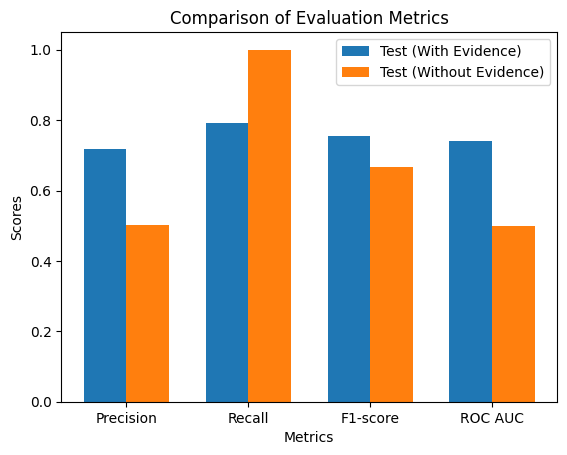

In [101]:
# Compare evaluation metrics and visualize the comparison
compare_evaluation_metrics(test_metrics_with_evidence, test_metrics_no_evidence)

# VALIDATION DATA COMPARISON WITH AND WITHOUT EVIDENCE

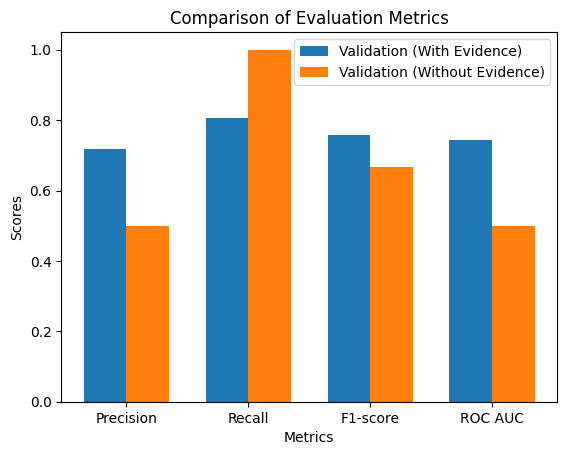

In [102]:
# Compare evaluation metrics and visualize the comparison
compare_evaluation_metrics_val(val_metrics_with_evidence, val_metrics_no_evidence)

# CONFUSTION MATRIX

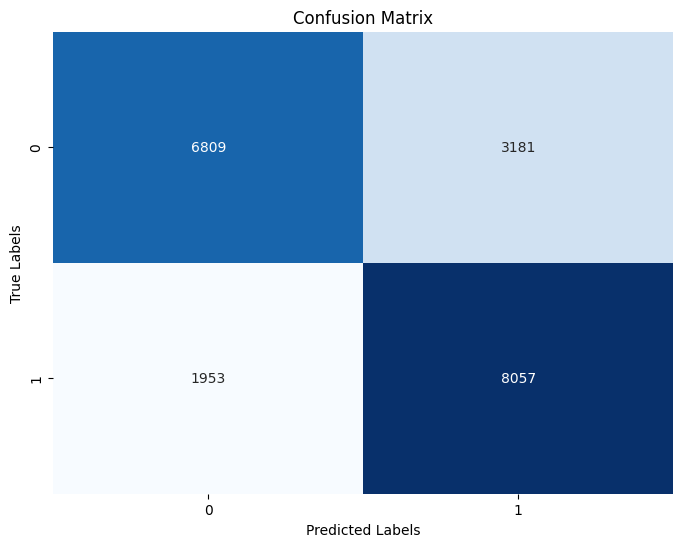

In [104]:
# Define true labels and predicted labels
true_labels = val_y_true  # Replace with your true labels
predicted_labels = val_y_pred  # Replace with your predicted labels

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# CORRELATION MATRIX

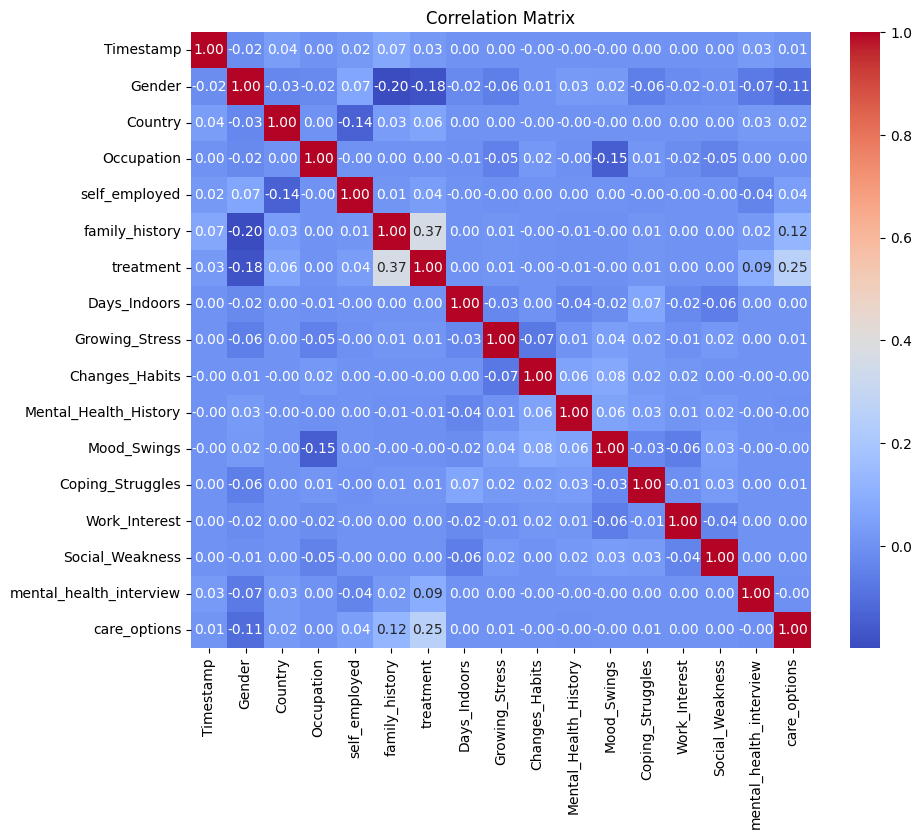

In [105]:


# Compute the correlation matrix
correlation_matrix = df_filled.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
